In [3]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [4]:
idx = pd.IndexSlice

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Load the data

In [7]:
fp = '../../prediction-data/final-data.csv'
uniq_fp = '../../prediction-data/uniq-final-data.csv'

base_df = pd.read_csv(fp, header=[0, 1])
base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

uniq_base_df = pd.read_csv(uniq_fp, header=[0, 1])
uniq_base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

def convert_time_cols(df):
    # convert time columns from us to s
    time_cols = list(filter(lambda c: 'time' in c.lower(), df.columns.get_level_values(level=1)))
    df.loc[:,idx[tuple(time_cols), slice(None)]] /= 1000000

    # rename from us to s
    renamed_time_cols = list(map(lambda col: col.replace('(us)', '(s)'), time_cols))
    renamed_cols_dict = dict(zip(time_cols, renamed_time_cols))
    df.rename(columns=renamed_cols_dict, level=0, inplace=True)
    df.rename(columns=renamed_cols_dict, level=1, inplace=True)
    
convert_time_cols(base_df)
convert_time_cols(uniq_base_df)

base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)
uniq_base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)

print('Base df shape: {}'.format(base_df.shape))
print('Uniq base df shape: {}'.format(uniq_base_df.shape))

/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Base df shape: (251478, 140)
Uniq base df shape: (191066, 140)


### Map the class names to values

In [47]:
class_map = {
    'astar': 0,
    'inc3': 1,
    'recomp-astar': 2,
    'recomp-inc3': 3
}

base_df.loc[:, ('Min', 'Total Time including setup (s) - id')] = base_df.loc[: , idx['Min', 'Total Time including setup (s)']].map(class_map)
base_df.loc[:, ('is_valid', 'all')] = base_df.loc[:, idx[('is_valid'), ('astar', 'inc3', 'recomp-astar', 'recomp-inc3')]].apply(lambda row: row.all(), axis=1)


/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Load the extra features

In [27]:
feature_dirpath = '../../prediction-data/features/'
fname_list = list(filter(lambda fname: 'extra' in fname, os.listdir(feature_dirpath)))

extra_feature_df_list = []

for fname in fname_list:
    fp = os.path.join(feature_dirpath, fname)
    net = fname.split('-')[0]
    assert os.path.isfile(fp) == True
    
    df = pd.read_csv(fp)
    df['model'] = net
    extra_feature_df_list.append(df)
    
#     print('df shape: {}'.format(df.shape))
    
extra_feature_df = pd.concat(extra_feature_df_list, axis=0)
extra_feature_df.rename(columns={'caseid': 'SP label'}, inplace=True)
extra_feature_df.set_index(['model', 'log', 'SP label'], inplace=True)
extra_feature_df.columns = pd.MultiIndex.from_product([['model_trace_features'], extra_feature_df.columns])

In [28]:
extra_feature_df.head()

model_trace_features                       \
                                snp_place_in_deg_min snp_place_in_deg_max   
model log              SP label                                             
net1  net1-10-10-l5000 1                           0                   10   
                       10                          0                   10   
                       100                         0                    8   
                       101                         0                    9   
                       102                         0                    7   

                                                                             \
                                snp_place_out_deg_min snp_place_out_deg_max   
model log              SP label                                               
net1  net1-10-10-l5000 1                            0                    12   
                       10                           0                    13   
                       100                          0                    12   
                       101                          0                    15   
                       102                          0                    11   

                                                        \
                                snp_n_place_one_in_deg   
model log              SP label                          
net1  net1-10-10-l5000 1                            84   
                       10                           69   
                       100                          94   
                       101                          71   
                       102                          86   

                                                                          \
                                snp_n_place_one_out_deg place_in_deg_min   
model log              SP label                                            
net1  net1-10-10-l5000 1                             79                1   
                       10                            72                1   
                       100                           92                1   
                       101                           71                1   
                       102                           85                1   

                                                                    \
                                place_in_deg_max place_out_deg_min   
model log              SP label                                      
net1  net1-10-10-l5000 1                       6                 0   
                       10                      6                 0   
                       100                     6                 0   
                       101                     6                 0   
                       102                     6                 0   

                                                                      \
                                place_out_deg_max n_place_one_in_deg   
model log              SP label                                        
net1  net1-10-10-l5000 1                       10                116   
                       10                      10                116   
                       100                     10                116   
                       101                     10                116   
                       102                     10                116   

                                                     
                                n_place_one_out_deg  
model log              SP label                      
net1  net1-10-10-l5000 1                        111  
                       10                       111  
                       100                      111  
                       101                      111  
                       102                      111

In [25]:
base_df.head()

Cost of the alignment       \
                                                              astar inc3   
model log              decomposition SP label                              
net3  net3-10-60-l5000 sese_25       1                            0    0   
                                     10                           0    0   
                                     100                        192  192   
                                     1000                       198  198   
                                     1001                         0    0   

                                                                        \
                                              recomp-astar recomp-inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                 0.0         0.0   
                                     10                0.0         0.0   
                                     100             192.0       192.0   
                                     1000            198.0       198.0   
                                     1001              0.0         0.0   

                                              Heuristics computed       \
                                                            astar inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                          1    1   
                                     10                         1    1   
                                     100                     1149    8   
                                     1000                    1390    9   
                                     1001                       1    1   

                                                                        \
                                              recomp-astar recomp-inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                  74          75   
                                     10                 74          76   
                                     100              1241          83   
                                     1000             1478          86   
                                     1001               74          74   

                                              Heuristics derived       \
                                                           astar inc3   
model log              decomposition SP label                           
net3  net3-10-60-l5000 sese_25       1                        85   85   
                                     10                       48   48   
                                     100                     563  212   
                                     1000                    618  355   
                                     1001                     85   85   

                                                    ...         \
                                                    ...          
model log              decomposition SP label       ...          
net3  net3-10-60-l5000 sese_25       1              ...          
                                     10             ...          
                                     100            ...          
                                     1000           ...          
                                     1001           ...          

                                                      model_trace_features  \
                                              subnet_n_inv_transition_mean   
model log              decomposition SP label                                
net3  net3-10-60-l5000 sese_25       1                             1.90625   
                                     10                            1.90625   
                                     100                           1.90625   
                                     1000                          1.90625  

In [71]:
merged_df = base_df.reset_index('decomposition').merge(extra_feature_df, on=['model', 'log', 'SP label'])
merged_df.loc[:, ('model_trace_features', 'snp_n_place_multiple_in_deg')] = merged_df.loc[:, ('model_trace_features', 'snp_n_place')] - merged_df.loc[:, ('model_trace_features', 'snp_n_place_one_in_deg')]
merged_df.loc[:, ('model_trace_features', 'snp_n_place_multiple_out_deg')] = merged_df.loc[:, ('model_trace_features', 'snp_n_place')] - merged_df.loc[:, ('model_trace_features', 'snp_n_place_one_out_deg')]


/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [49]:
extra_feature_df.columns.get_level_values(level=1)

Index(['snp_place_in_deg_min', 'snp_place_in_deg_max', 'snp_place_out_deg_min',
       'snp_place_out_deg_max', 'snp_n_place_one_in_deg',
       'snp_n_place_one_out_deg', 'place_in_deg_min', 'place_in_deg_max',
       'place_out_deg_min', 'place_out_deg_max', 'n_place_one_in_deg',
       'n_place_one_out_deg'],
      dtype='object')

In [80]:
merged_df.columns.get_level_values(level=0).unique()

Index(['decomposition', 'Cost of the alignment', 'Heuristics computed',
       'Heuristics derived', 'Heuristics estimated',
       'Markings added to closed set', 'Markings polled from queue',
       'Markings queued', 'Markings reached', 'Min',
       'Time to compute alignment (s)', 'Total Time including setup (s)',
       'is_valid', 'n_invis_move', 'n_log_move', 'n_model_move', 'n_sync_move',
       'result_dir', 'model_trace_features'],
      dtype='object')

### Get the number of restarts

In [81]:
merged_df.loc[:, idx['result_dir', :]].head()

result_dir  \
                                                                                                                             astar   
model log              SP label                                                                                                      
net3  net3-10-60-l5000 1         ./results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9   
                       10        ./results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9   
                       100       ./results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9   
                       1000      ./results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9   
                       1001      ./results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9   

                                                                                                                                   \
                                                                                                                             inc3   
model log              SP label                                                                                                     
net3  net3-10-60-l5000 1         ./results-agg/clst-2018-12-sese_25-net3/2018-12-11_19-15-26-823114_BPI2018-net3-nILP-inc3-mono/9   
                       10        ./results-agg/clst-2018-12-sese_25-net3/2018-12-11_19-15-26-823114_BPI2018-net3-nILP-inc3-mono/9   
                       100       ./results-agg/clst-2018-12-sese_25-net3/2018-12-11_19-15-26-823114_BPI2018-net3-nILP-inc3-mono/9   
                       1000      ./results-agg/clst-2018-12-sese_25-net3/2018-12-11_19-15-26-823114_BPI2018-net3-nILP-inc3-mono/9   
                       1001      ./results-agg/clst-2018-12-sese_25-net3/2018-12-11_19-15-26-823114_BPI2018-net3-nILP-inc3-mono/9   

                                                                                                                                                    \
                                                                                                                                      recomp-astar   
model log              SP label                                                                                                                      
net3  net3-10-60-l5000 1         ./results-agg/clst-2018-12-sese_25-net3/2018-12-16_00-30-06-092310_BPI2018-net3-nILP-astar-sese_25-score-strict/9   
                       10        ./results-agg/clst-2018-12-sese_25-net3/2018-12-16_00-30-06-092310_BPI2018-net3-nILP-astar-sese_25-score-strict/9   
                       100       ./results-agg/clst-2018-12-sese_25-net3/2018-12-16_00-30-06-092310_BPI2018-net3-nILP-astar-sese_25-score-strict/9   
                       1000      ./results-agg/clst-2018-12-sese_25-net3/2018-12-16_00-30-06-092310_BPI2018-net3-nILP-astar-sese_25-score-strict/9   
                       1001      ./results-agg/clst-2018-12-sese_25-net3/2018-12-16_00-30-06-092310_BPI2018-net3-nILP-astar-sese_25-score-strict/9   

                                                                                                                                                     
                                                                                                                                        recomp-inc3  
model log              SP label                                                                                                                      
net3  net3-10-60-l5000 1         ./results-agg/clst-2018-12-sese_25-net3/2019-01-19_10-57-47-777436_BPI2018-net3-repeat-inc3-sese_25-score-strict/0  
                       10        ./results-agg/clst-2018-12-sese_25-net3/2019-01-19_10-57-47-777436_BPI2018-net3-repeat-inc3-sese_25-score-strict/0  
                       100     

In [97]:
all_valid = base_df.loc[:, ('is_valid', 'all')] == True
inc3_invalid = base_df.loc[:, ('is_valid', 'inc3')] == False
has_invalid_df = base_df.loc[~all_valid, :]
inc3_invalid_df = base_df.loc[inc3_invalid, :]

In [182]:
astar_invalid = base_df.loc[:, ('is_valid', 'astar')] == False
astar_invalid_df = base_df.loc[astar_invalid, idx['Total Time including setup (s)', :]]

In [185]:
astar_invalid_df

Total Time including setup (s)  \
                                                                       astar   
model log              decomposition SP label                                  
net2  net2-10-60-l5000 generic_50    748                          299.945700   
      net2-60-60-l5000 generic_50    621                          299.940122   
      net2-noisy-l1000 generic_50    3611                         299.701881   
                                     62                           299.712364   
      net2-60-10-l5000 generic_50    1522                         299.966125   
net5  net5-10-60-l5000 sese_25       1511                         299.952512   
                                     4813                         299.953061   
      net5-60-10-l5000 sese_25       2069                         299.944497   
net1  net1-10-60-l5000 sese_25       291                          299.943738   
                                     3394                         299.947149   
      net1-60-60-l5000 sese_25       1961                         299.950561   
                                     291                          299.943029   
net4  net4-60-10-l5000 generic_50    582                          299.952554   
                                     3525                         299.956793   
                                     4370                         299.953809   
      net4-60-60-l5000 generic_50    562                          299.946541   
                                     1420                         299.948464   
      net4-10-10-l5000 generic_50    582                          299.945547   
      net4-10-60-l5000 generic_50    1357                         299.952425   
                                     3248                         299.947964   
                                     4258                         299.940764   
                                     4313                         299.945483   
      net4-60-10-l5000 sese_25       2915                         299.965232   
                                     3525                         299.956793   
                                     4370                         299.953809   
                                     582                          299.952554   
      net4-60-60-l5000 sese_25       562                          299.946541   
      net4-10-10-l5000 sese_25       582                          299.945547   
      net4-10-60-l5000 sese_25       1357                         299.952425   
                                     3248                         299.947964   
...                                                                      ...   
P284  L48              sese_manual   case_264                     299.707467   
                                     case_325                     299.700175   
                                     case_365                     299.703458   
                                     case_401                     299.703536   
                                     case_410                     299.704151   
                                     case_429                     299.719128   
                                     case_464                     299.702053   
                                     case_474                     299.700902   
                                     case_478                     299.710785   
                                     case_562                     299.706504   
                                     case_6                       299.710310   
                                     case_62                      299.709957   
                                     case_655                     299.716831   
                                     case_764                     299.710666   
                                     case_767                     299.707137   
                                     case_797                     299.711512   
                                     case_812 

In [162]:
inc3_invalid_df.loc[:, idx['result_dir', :]]

result_dir  \
                                                                                                                                               astar   
model log              decomposition SP label                                                                                                          
net2  net2-10-60-l5000 generic_50    2819       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/9   
                                     3117       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/9   
      net2-60-60-l5000 generic_50    193       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     2211      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     234       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     2744      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     2819      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     3239      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     3426      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     3482      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     3910      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     424       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     4562      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     4763      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     4874      ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     621       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
                                     926       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/15   
      net2-noisy-l1000 generic_50    3611       ./results-agg/clst-2018-12-generic_50-net2/2018-12-06_18-12-52-692380_BPI2018-net2-nILP-astar-mono/0   
net5  net5-60-60-l5000 sese_25       4271         ./results-agg/clst-2018-12-sese_25-net5/2018-12-06_18-13-00-922665_BPI2018-net5-nILP-astar-mono/15   
net1  net1-60-60-l5000 sese_25       1961         ./results-agg/clst-2018-12-sese_25-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/15   
                                     2284         ./results-agg/clst-2018-12-sese_25-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/15   
                                     291          ./results-agg/clst-2018-12-sese_25-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/15   
                                     2937         ./results-agg/clst-2018-12-sese_25-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/15   
                                     2958         ./results-agg/clst-2018-12-sese_25-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/15   
                                  

In [164]:
# inc3_invalid_df.loc[:, idx['Total Time including setup (s)', :]]
k = 2
beat_by_k_times = inc3_invalid_df.loc[:, ('Total Time including setup (s)', 'astar')] * k < inc3_invalid_df.loc[:, ('Total Time including setup (s)', 'inc3')]
inc3_invalid_k_df = inc3_invalid_df.loc[beat_by_k_times, :]

In [178]:
temp_df = base_df.loc[base_df.loc[:,('Min', 'Total Time including setup (s)')] == 'inc3', :].reset_index('SP label')
temp_df = temp_df.loc[:, idx[('SP label', 'result_dir'), ('astar', '')]].values

In [180]:
temp_df

array([[100,
        './results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9'],
       [1000,
        './results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9'],
       [1008,
        './results-agg/clst-2018-12-sese_25-net3/2018-12-06_18-13-01-058087_BPI2018-net3-nILP-astar-mono/9'],
       ...,
       [952,
        './results-agg/clst-2018-12-generic_50-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/6'],
       [97,
        './results-agg/clst-2018-12-generic_50-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/6'],
       [99,
        './results-agg/clst-2018-12-generic_50-net1/2018-12-06_18-12-52-669712_BPI2018-net1-nILP-astar-mono/6']],
      dtype=object)

In [181]:
valid_dfs = [get_extra_stats(row[0], row[1], extra_stats_colnames) for row in temp_df]

KeyboardInterrupt: 

In [173]:
temp_df.shape

(39652, 143)

In [171]:
def get_extra_stats(caseid, result_dir, colnames):
    split_path = result_dir.split('/')
    split_path[2] = 'clst_2018_12'
    split_path[0] = '../..'
    modified_dir = os.sep.join(split_path)
    
    stats_fp = os.path.join(modified_dir, 'trace-stats.csv')
    
    if not os.path.isfile(stats_fp):
        print('Not file: {}'.format(stats_fp))
        return pd.Series([np.nan for _ in range(len(colnames))], index=colnames)
#     print(stats_fp)
#     print(caseid)
    stats_df = pd.read_csv(stats_fp)
    caseid_row_condition = stats_df.loc[:, 'SP label'] == str(caseid)
    extra_stats = stats_df.loc[caseid_row_condition, colnames]
#     extra_stats['SP label'] = caseid
    return extra_stats

extra_stats_colnames = [
    'Number of splits when splitting marking',
    'Number of times replay was restarted',
    'Size of the constraintset'
]

dfs = inc3_invalid_df.reset_index('SP label').apply(lambda row: get_extra_stats(row['SP label'].values[0], row['result_dir'].values[1], extra_stats_colnames), axis=1)
df = pd.concat(list(dfs))

# valid_dfs = .apply(lambda row: get_extra_stats(row['SP label'].values[0], row['result_dir'].values[1], extra_stats_colnames), axis=1)
# valid_df = pd.concat(list(valid_dfs))

Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/7/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/7/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/7/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/11/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/11/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/4/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/5/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969

Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_IS2017-2-nILP-inc3-BPI2018-P297-nILP-inc3-mono/8/trace-stats.csv
Not file: ../../results-agg/clst_2018_12/2019-01-23_19-12-21-014969_I

KeyboardInterrupt: 

In [154]:
inc3_invalid_df.loc[:, 'model_trace_features'].reset_index().to_csv('./invalid-inc3.csv', index=False)

In [152]:
df.head()

,Number of splits when splitting marking,Number of times replay was restarted,Size of the constraintset
2819,34,31,0
3117,31,28,0
193,78,75,0
2211,74,71,0
234,28,25,0


In [161]:
inc3_invalid_desc = inc3_invalid_df.loc[:, idx['model_trace_features', :]].describe()
inc3_valid_desc = base_df.loc[(base_df.loc[:, ('Min', 'Total Time including setup (s)')] == 'inc3'), idx['model_trace_features', :]].describe()

inc3_desc = pd.concat([inc3_invalid_desc, inc3_valid_desc], keys=['invalid', 'min'])
inc3_desc.to_csv('./inc3_desc_min.csv', index=True)

In [158]:
base_df.loc[(base_df.loc[:, ('is_valid', 'inc3')] == True), idx['model_trace_features', :]].describe()

model_trace_features                                      \
              trace_length     n_activity activity_repeat_mean   
count        251424.000000  251424.000000        251424.000000   
mean             71.822813      54.466244             1.277391   
std              35.932037      15.262989             0.329248   
min               1.000000       1.000000             1.000000   
25%              49.000000      43.000000             1.075758   
50%              61.000000      51.000000             1.181818   
75%              85.000000      64.000000             1.353846   
max             419.000000     142.000000             6.758065   

                                                                 \
      activity_repeat_std snp_n_transition snp_n_inv_transition   
count       251424.000000    251424.000000        251424.000000   
mean             0.673182       389.070805            28.529806   
std              0.620557        74.469500             4.053489   
min              0.000000       165.000000            18.000000   
25%              0.300327       345.000000            25.000000   
50%              0.537235       372.000000            30.000000   
75%              0.869608       415.000000            30.000000   
max             11.995471      1081.000000            58.000000   

                                                  \
      snp_n_dup_transition snp_n_uniq_transition   
count        251424.000000         251424.000000   
mean             51.929633            308.611366   
std              67.022942             27.814684   
min               0.000000            111.000000   
25%              12.000000            297.000000   
50%              30.000000            310.000000   
75%              64.000000            324.000000   
max             782.000000            412.000000   

                                                                          \
      snp_inv_transition_in_degree_mean snp_inv_transition_in_degree_std   
count                     251424.000000                    251424.000000   
mean                           1.491309                         0.629535   
std                            0.205190                         0.214193   
min                            1.206897                         0.408619   
25%                            1.433333                         0.568321   
50%                            1.437500                         0.568321   
75%                            1.440000                         0.583095   
max                            3.055556                         2.261499   

            ...                                      \
            ...        subnet_n_inv_transition_mean   
count       ...                       251424.000000   
mean        ...                            2.747892   
std         ...                            1.843938   
min         ...                            1.750000   
25%         ...                            1.934426   
50%         ...                            2.711864   
75%         ...                            2.785714   
max         ...                           19.666667   

                                                                \
      subnet_n_inv_transition_std subnet_n_dup_transition_mean   
count               251424.000000                     251424.0   
mean                     5.389738                          0.0   
std                      2.985704                          0.0   
min                      3.707093                          0.0   
25%                      4.599266                          0.0   
50%                      4.699171                          0.0   
75%                      5.173487                          0.0   
max                     33.201406                          0.0   

                                                                 \
      subnet_n_dup_transition_std subnet_n_uniq_transition_mean   
count                    251424.0             

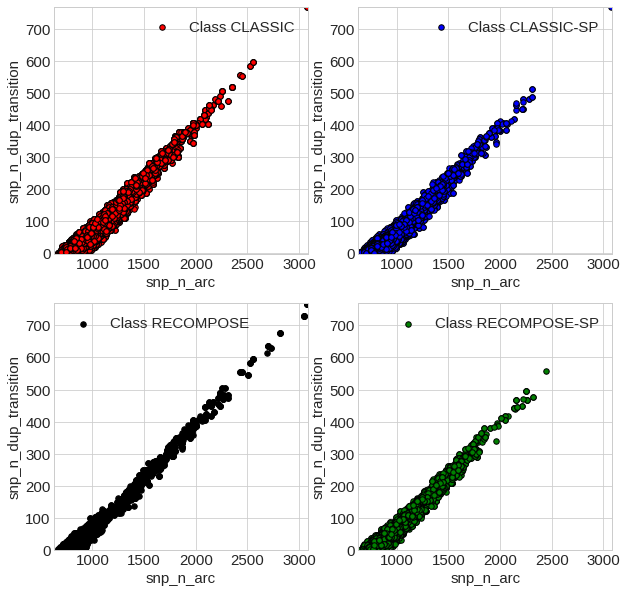

In [167]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(10, 10), ncols=ncols, nrows=nrows)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'black', 'green'
]
plot_step = 0.02

f1 = 'snp_n_dup_transition'
f0 = 'snp_n_arc'
X_df = merged_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
X_df.columns = X_df.columns.droplevel(level=0)
X_df = X_df[[f0, f1]]
X = X_df.values

x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

row = 0
col = 0

for i, n, c in zip(range(4), class_names, plot_colors):
    ax = axes[row, col]
    row = row if col < 1 else row + 1
    col = col + 1 if col < 1 else 0
    ind = np.where(merged_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
    ax.scatter(X[ind, 0], X[ind, 1],
              c=c, cmap=plt.cm.Paired,
              s=30, edgecolor='k',
              label='Class {}'.format(n))
    
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

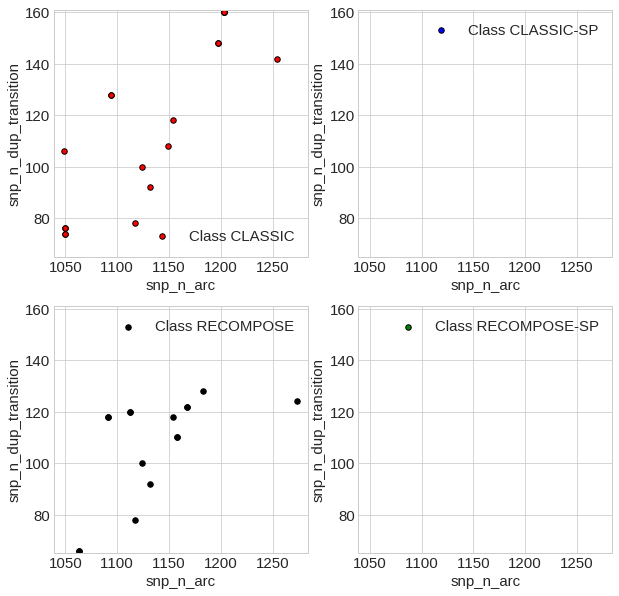

In [168]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(10, 10), ncols=ncols, nrows=nrows)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'black', 'green'
]
plot_step = 0.02

f1 = 'snp_n_dup_transition'
f0 = 'snp_n_arc'
X_df = inc3_invalid_k_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
X_df.columns = X_df.columns.droplevel(level=0)
X_df = X_df[[f0, f1]]
X = X_df.values

x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

row = 0
col = 0

for i, n, c in zip(range(4), class_names, plot_colors):
    ax = axes[row, col]
    row = row if col < 1 else row + 1
    col = col + 1 if col < 1 else 0
    ind = np.where(inc3_invalid_k_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
    ax.scatter(X[ind, 0], X[ind, 1],
              c=c, cmap=plt.cm.Paired,
              s=30, edgecolor='k',
              label='Class {}'.format(n))
    
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()